In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_TSNE3_TSNE3.pth'


/home/guangwei/miniconda3/envs/sit/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states/reference embeddings
from sklearn.manifold import TSNE
def extract_hidden_states(texts, model, tokenizer, apply_tsne=True, n_components=3, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_state = outputs.hidden_states[-1].mean(dim=1).cpu().numpy()
        hidden_states.append(hidden_state)

    hidden_states = np.vstack(hidden_states)
    if apply_tsne:
        tsne = TSNE(n_components=n_components, random_state=42)
        hidden_states = tsne.fit_transform(hidden_states)
        print(f"Hidden states reduced to {n_components} dimensions using t-SNE.")
        
    return hidden_states

def extract_reference_embeddings(references, model, tokenizer, apply_tsne=True, n_components=3, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())  # 提取池化后的输出

    embeddings = np.vstack(embeddings)
    
    # 应用 t-SNE
    if apply_tsne:
        tsne = TSNE(n_components=n_components, random_state=42)
        embeddings = tsne.fit_transform(embeddings)
        print(f"Reference embeddings reduced to {n_components} dimensions using t-SNE.")
    
    return embeddings

In [4]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [5]:
# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with accuracy {best_accuracy * 100:.2f}% at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    
    return custom_mlp, losses, best_accuracy

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]
/home/guangwei/miniconda3/envs/sit/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 373/373 [01:48<00:00,  3.44it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Hidden states reduced to 3 dimensions using t-SNE.
Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 373/373 [00:03<00:00, 99.81it/s] 


Reference embeddings reduced to 3 dimensions using t-SNE.
Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 354/354 [02:07<00:00,  2.78it/s]


Hidden states reduced to 3 dimensions using t-SNE.
Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 354/354 [00:03<00:00, 97.32it/s] 


Reference embeddings reduced to 3 dimensions using t-SNE.


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=6 and hidden_dim=256


Training Epochs:   0%|          | 7/2000 [00:00<00:29, 67.07it/s]

Epoch 10/2000, Loss: 4.4739
Test Accuracy at Epoch 10: 41.82%
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.40      0.37      0.38       283
non_infringement       0.44      0.47      0.45       298

        accuracy                           0.42       581
       macro avg       0.42      0.42      0.42       581
    weighted avg       0.42      0.42      0.42       581

New best model saved with accuracy 41.82% at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.40      0.37      0.38       283
non_infringement       0.44      0.47      0.45       298

        accuracy                           0.42       581
       macro avg       0.42      0.42      0.42       581
    weighted avg       0.42      0.42      0.42       581



Training Epochs:   2%|▏         | 30/2000 [00:00<00:20, 97.35it/s]

Epoch 20/2000, Loss: 2.7177
Test Accuracy at Epoch 20: 47.33%
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.44      0.33      0.38       283
non_infringement       0.49      0.61      0.54       298

        accuracy                           0.47       581
       macro avg       0.47      0.47      0.46       581
    weighted avg       0.47      0.47      0.46       581

New best model saved with accuracy 47.33% at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.44      0.33      0.38       283
non_infringement       0.49      0.61      0.54       298

        accuracy                           0.47       581
       macro avg       0.47      0.47      0.46       581
    weighted avg       0.47      0.47      0.46       581

Epoch 30/2000, Loss: 1.6209
Test Accuracy at Epoch 30: 49.74%
Classification Report at Epoch 30:
          

Training Epochs:   3%|▎         | 52/2000 [00:00<00:20, 94.11it/s]

Epoch 40/2000, Loss: 1.0152
Test Accuracy at Epoch 40: 48.02%
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.46      0.39      0.42       283
non_infringement       0.49      0.57      0.53       298

        accuracy                           0.48       581
       macro avg       0.48      0.48      0.47       581
    weighted avg       0.48      0.48      0.48       581

Epoch 50/2000, Loss: 0.7290
Test Accuracy at Epoch 50: 52.84%
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.52      0.42      0.47       283
non_infringement       0.53      0.63      0.58       298

        accuracy                           0.53       581
       macro avg       0.53      0.53      0.52       581
    weighted avg       0.53      0.53      0.52       581

New best model saved with accuracy 52.84% at epoch 50
Best Classification Report at Epoch 50:
          

Training Epochs:   4%|▍         | 76/2000 [00:00<00:20, 91.78it/s] 

Epoch 70/2000, Loss: 0.4452
Test Accuracy at Epoch 70: 53.70%
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.53      0.51      0.52       283
non_infringement       0.55      0.56      0.55       298

        accuracy                           0.54       581
       macro avg       0.54      0.54      0.54       581
    weighted avg       0.54      0.54      0.54       581

New best model saved with accuracy 53.70% at epoch 70
Best Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.53      0.51      0.52       283
non_infringement       0.55      0.56      0.55       298

        accuracy                           0.54       581
       macro avg       0.54      0.54      0.54       581
    weighted avg       0.54      0.54      0.54       581

Epoch 80/2000, Loss: 0.3773
Test Accuracy at Epoch 80: 54.04%
Classification Report at Epoch 80:
          

Training Epochs:   5%|▌         | 102/2000 [00:01<00:17, 106.51it/s]

Epoch 90/2000, Loss: 0.3364
Test Accuracy at Epoch 90: 55.42%
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.54      0.54      0.54       283
non_infringement       0.57      0.56      0.56       298

        accuracy                           0.55       581
       macro avg       0.55      0.55      0.55       581
    weighted avg       0.55      0.55      0.55       581

New best model saved with accuracy 55.42% at epoch 90
Best Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.54      0.54      0.54       283
non_infringement       0.57      0.56      0.56       298

        accuracy                           0.55       581
       macro avg       0.55      0.55      0.55       581
    weighted avg       0.55      0.55      0.55       581

Epoch 100/2000, Loss: 0.3038
Test Accuracy at Epoch 100: 57.66%
Classification Report at Epoch 100:
       

Training Epochs:   7%|▋         | 140/2000 [00:01<00:17, 104.68it/s]

Epoch 120/2000, Loss: 0.2562
Test Accuracy at Epoch 120: 59.04%
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.58      0.60      0.59       283
non_infringement       0.60      0.58      0.59       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

Epoch 130/2000, Loss: 0.2379
Test Accuracy at Epoch 130: 59.38%
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.58      0.60      0.59       283
non_infringement       0.61      0.59      0.60       298

        accuracy                           0.59       581
       macro avg       0.59      0.59      0.59       581
    weighted avg       0.59      0.59      0.59       581

New best model saved with accuracy 59.38% at epoch 130
Best Classification Report at Epoch 130:
  

Training Epochs:   8%|▊         | 165/2000 [00:01<00:18, 100.93it/s]

Epoch 150/2000, Loss: 0.2082
Test Accuracy at Epoch 150: 60.76%
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.60      0.60      0.60       283
non_infringement       0.62      0.61      0.61       298

        accuracy                           0.61       581
       macro avg       0.61      0.61      0.61       581
    weighted avg       0.61      0.61      0.61       581

New best model saved with accuracy 60.76% at epoch 150
Best Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.60      0.60      0.60       283
non_infringement       0.62      0.61      0.61       298

        accuracy                           0.61       581
       macro avg       0.61      0.61      0.61       581
    weighted avg       0.61      0.61      0.61       581

Epoch 160/2000, Loss: 0.1957
Test Accuracy at Epoch 160: 61.27%
Classification Report at Epoch 160:
  

Training Epochs:  10%|▉         | 192/2000 [00:01<00:15, 114.94it/s]

Epoch 170/2000, Loss: 0.1846
Test Accuracy at Epoch 170: 61.96%
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.61      0.61      0.61       283
non_infringement       0.63      0.62      0.63       298

        accuracy                           0.62       581
       macro avg       0.62      0.62      0.62       581
    weighted avg       0.62      0.62      0.62       581

New best model saved with accuracy 61.96% at epoch 170
Best Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.61      0.61      0.61       283
non_infringement       0.63      0.62      0.63       298

        accuracy                           0.62       581
       macro avg       0.62      0.62      0.62       581
    weighted avg       0.62      0.62      0.62       581

Epoch 180/2000, Loss: 0.1745
Test Accuracy at Epoch 180: 61.96%
Classification Report at Epoch 180:
  

Training Epochs:  10%|█         | 204/2000 [00:01<00:15, 115.57it/s]

Epoch 200/2000, Loss: 0.1569
Test Accuracy at Epoch 200: 63.17%
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.62      0.62      0.62       283
non_infringement       0.64      0.64      0.64       298

        accuracy                           0.63       581
       macro avg       0.63      0.63      0.63       581
    weighted avg       0.63      0.63      0.63       581

New best model saved with accuracy 63.17% at epoch 200
Best Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.62      0.62      0.62       283
non_infringement       0.64      0.64      0.64       298

        accuracy                           0.63       581
       macro avg       0.63      0.63      0.63       581
    weighted avg       0.63      0.63      0.63       581

Epoch 210/2000, Loss: 0.1492
Test Accuracy at Epoch 210: 62.99%
Classification Report at Epoch 210:
  

Training Epochs:  11%|█▏        | 228/2000 [00:02<00:18, 97.75it/s] 

Epoch 220/2000, Loss: 0.1422
Test Accuracy at Epoch 220: 63.34%
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.62      0.62      0.62       283
non_infringement       0.64      0.64      0.64       298

        accuracy                           0.63       581
       macro avg       0.63      0.63      0.63       581
    weighted avg       0.63      0.63      0.63       581

New best model saved with accuracy 63.34% at epoch 220
Best Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.62      0.62      0.62       283
non_infringement       0.64      0.64      0.64       298

        accuracy                           0.63       581
       macro avg       0.63      0.63      0.63       581
    weighted avg       0.63      0.63      0.63       581

Epoch 230/2000, Loss: 0.1359
Test Accuracy at Epoch 230: 63.68%
Classification Report at Epoch 230:
  

Training Epochs:  13%|█▎        | 255/2000 [00:02<00:16, 102.81it/s]

Epoch 240/2000, Loss: 0.1302
Test Accuracy at Epoch 240: 63.34%
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.62      0.62      0.62       283
non_infringement       0.64      0.64      0.64       298

        accuracy                           0.63       581
       macro avg       0.63      0.63      0.63       581
    weighted avg       0.63      0.63      0.63       581

Epoch 250/2000, Loss: 0.1250
Test Accuracy at Epoch 250: 63.17%
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.62      0.62      0.62       283
non_infringement       0.64      0.64      0.64       298

        accuracy                           0.63       581
       macro avg       0.63      0.63      0.63       581
    weighted avg       0.63      0.63      0.63       581

Epoch 260/2000, Loss: 0.1201
Test Accuracy at Epoch 260: 63.51%
Classification Report at Epoch 260

Training Epochs:  14%|█▍        | 282/2000 [00:02<00:14, 115.48it/s]

Epoch 270/2000, Loss: 0.1156
Test Accuracy at Epoch 270: 63.68%
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.63      0.63      0.63       283
non_infringement       0.65      0.64      0.64       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.64       581
    weighted avg       0.64      0.64      0.64       581

Epoch 280/2000, Loss: 0.1113
Test Accuracy at Epoch 280: 63.51%
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.62      0.63      0.63       283
non_infringement       0.65      0.64      0.64       298

        accuracy                           0.64       581
       macro avg       0.63      0.63      0.63       581
    weighted avg       0.64      0.64      0.64       581

Epoch 290/2000, Loss: 0.1073
Test Accuracy at Epoch 290: 63.68%


Training Epochs:  16%|█▌        | 310/2000 [00:02<00:14, 114.29it/s]

Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.62      0.64      0.63       283
non_infringement       0.65      0.64      0.64       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.64       581
    weighted avg       0.64      0.64      0.64       581

Epoch 300/2000, Loss: 0.1035
Test Accuracy at Epoch 300: 63.68%
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.62      0.64      0.63       283
non_infringement       0.65      0.63      0.64       298

        accuracy                           0.64       581
       macro avg       0.64      0.64      0.64       581
    weighted avg       0.64      0.64      0.64       581

Epoch 310/2000, Loss: 0.0999
Test Accuracy at Epoch 310: 64.20%
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

   

Training Epochs:  17%|█▋        | 338/2000 [00:03<00:14, 111.57it/s]

Epoch 320/2000, Loss: 0.0965
Test Accuracy at Epoch 320: 64.72%
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.64      0.64      0.64       283
non_infringement       0.66      0.65      0.65       298

        accuracy                           0.65       581
       macro avg       0.65      0.65      0.65       581
    weighted avg       0.65      0.65      0.65       581

New best model saved with accuracy 64.72% at epoch 320
Best Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.64      0.64      0.64       283
non_infringement       0.66      0.65      0.65       298

        accuracy                           0.65       581
       macro avg       0.65      0.65      0.65       581
    weighted avg       0.65      0.65      0.65       581

Epoch 330/2000, Loss: 0.0932
Test Accuracy at Epoch 330: 64.72%
Classification Report at Epoch 330:
  

Training Epochs:  18%|█▊        | 362/2000 [00:03<00:14, 113.23it/s]

Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.64      0.64      0.64       283
non_infringement       0.66      0.65      0.65       298

        accuracy                           0.65       581
       macro avg       0.65      0.65      0.65       581
    weighted avg       0.65      0.65      0.65       581

Epoch 350/2000, Loss: 0.0871
Test Accuracy at Epoch 350: 64.89%
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.64      0.64      0.64       283
non_infringement       0.66      0.65      0.66       298

        accuracy                           0.65       581
       macro avg       0.65      0.65      0.65       581
    weighted avg       0.65      0.65      0.65       581

New best model saved with accuracy 64.89% at epoch 350
Best Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    inf

Training Epochs:  19%|█▉        | 387/2000 [00:03<00:15, 106.06it/s]

Epoch 370/2000, Loss: 0.0816
Test Accuracy at Epoch 370: 64.72%
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.64      0.65      0.64       283
non_infringement       0.66      0.65      0.65       298

        accuracy                           0.65       581
       macro avg       0.65      0.65      0.65       581
    weighted avg       0.65      0.65      0.65       581

Epoch 380/2000, Loss: 0.0789
Test Accuracy at Epoch 380: 64.89%
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.64      0.65      0.64       283
non_infringement       0.66      0.65      0.65       298

        accuracy                           0.65       581
       macro avg       0.65      0.65      0.65       581
    weighted avg       0.65      0.65      0.65       581



Training Epochs:  21%|██        | 415/2000 [00:03<00:13, 121.28it/s]

Epoch 390/2000, Loss: 0.0764
Test Accuracy at Epoch 390: 65.23%
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.64      0.65      0.65       283
non_infringement       0.66      0.65      0.66       298

        accuracy                           0.65       581
       macro avg       0.65      0.65      0.65       581
    weighted avg       0.65      0.65      0.65       581

New best model saved with accuracy 65.23% at epoch 390
Best Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.64      0.65      0.65       283
non_infringement       0.66      0.65      0.66       298

        accuracy                           0.65       581
       macro avg       0.65      0.65      0.65       581
    weighted avg       0.65      0.65      0.65       581

Epoch 400/2000, Loss: 0.0740
Test Accuracy at Epoch 400: 65.40%
Classification Report at Epoch 400:
  

Training Epochs:  21%|██▏       | 428/2000 [00:04<00:14, 108.71it/s]

Epoch 420/2000, Loss: 0.0694
Test Accuracy at Epoch 420: 65.75%
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.65      0.65      0.65       283
non_infringement       0.67      0.66      0.66       298

        accuracy                           0.66       581
       macro avg       0.66      0.66      0.66       581
    weighted avg       0.66      0.66      0.66       581

New best model saved with accuracy 65.75% at epoch 420
Best Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.65      0.65      0.65       283
non_infringement       0.67      0.66      0.66       298

        accuracy                           0.66       581
       macro avg       0.66      0.66      0.66       581
    weighted avg       0.66      0.66      0.66       581

Epoch 430/2000, Loss: 0.0673
Test Accuracy at Epoch 430: 65.75%
Classification Report at Epoch 430:
  

Training Epochs:  23%|██▎       | 453/2000 [00:04<00:14, 104.39it/s]

Epoch 440/2000, Loss: 0.0652
Test Accuracy at Epoch 440: 66.09%
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.65      0.66      0.65       283
non_infringement       0.67      0.66      0.67       298

        accuracy                           0.66       581
       macro avg       0.66      0.66      0.66       581
    weighted avg       0.66      0.66      0.66       581

New best model saved with accuracy 66.09% at epoch 440
Best Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.65      0.66      0.65       283
non_infringement       0.67      0.66      0.67       298

        accuracy                           0.66       581
       macro avg       0.66      0.66      0.66       581
    weighted avg       0.66      0.66      0.66       581

Epoch 450/2000, Loss: 0.0632
Test Accuracy at Epoch 450: 66.09%
Classification Report at Epoch 450:
  

Training Epochs:  24%|██▍       | 476/2000 [00:04<00:15, 99.78it/s] 

Epoch 460/2000, Loss: 0.0613
Test Accuracy at Epoch 460: 66.27%
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.65      0.66      0.66       283
non_infringement       0.67      0.66      0.67       298

        accuracy                           0.66       581
       macro avg       0.66      0.66      0.66       581
    weighted avg       0.66      0.66      0.66       581

New best model saved with accuracy 66.27% at epoch 460
Best Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.65      0.66      0.66       283
non_infringement       0.67      0.66      0.67       298

        accuracy                           0.66       581
       macro avg       0.66      0.66      0.66       581
    weighted avg       0.66      0.66      0.66       581

Epoch 470/2000, Loss: 0.0594
Test Accuracy at Epoch 470: 66.95%
Classification Report at Epoch 470:
  

Training Epochs:  25%|██▌       | 503/2000 [00:04<00:14, 102.40it/s]

Epoch 490/2000, Loss: 0.0559
Test Accuracy at Epoch 490: 67.47%
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.66      0.68      0.67       283
non_infringement       0.69      0.67      0.68       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.68      0.67      0.67       581

New best model saved with accuracy 67.47% at epoch 490
Best Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.66      0.68      0.67       283
non_infringement       0.69      0.67      0.68       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.68      0.67      0.67       581

Epoch 500/2000, Loss: 0.0542
Test Accuracy at Epoch 500: 67.13%
Classification Report at Epoch 500:
  

Training Epochs:  26%|██▋       | 530/2000 [00:05<00:12, 114.38it/s]

Epoch 510/2000, Loss: 0.0526
Test Accuracy at Epoch 510: 67.30%
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.66      0.68      0.67       283
non_infringement       0.69      0.66      0.68       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581

Epoch 520/2000, Loss: 0.0511
Test Accuracy at Epoch 520: 67.30%
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.66      0.68      0.67       283
non_infringement       0.69      0.66      0.68       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581

Epoch 530/2000, Loss: 0.0496
Test Accuracy at Epoch 530: 67.30%
Classification Report at Epoch 530

Training Epochs:  28%|██▊       | 559/2000 [00:05<00:12, 115.01it/s]

Epoch 540/2000, Loss: 0.0481
Test Accuracy at Epoch 540: 67.47%
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.66      0.68      0.67       283
non_infringement       0.69      0.67      0.68       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.68      0.67      0.67       581

Epoch 550/2000, Loss: 0.0468
Test Accuracy at Epoch 550: 67.64%
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.66      0.68      0.67       283
non_infringement       0.69      0.67      0.68       298

        accuracy                           0.68       581
       macro avg       0.68      0.68      0.68       581
    weighted avg       0.68      0.68      0.68       581

New best model saved with accuracy 67.64% at epoch 550
Best Classification Report at Epoch 550:
  

Training Epochs:  29%|██▉       | 585/2000 [00:05<00:11, 120.97it/s]

Epoch 570/2000, Loss: 0.0441
Test Accuracy at Epoch 570: 67.13%
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.66      0.67      0.67       283
non_infringement       0.68      0.67      0.68       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581

Epoch 580/2000, Loss: 0.0429
Test Accuracy at Epoch 580: 67.47%
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.66      0.67      0.67       283
non_infringement       0.68      0.68      0.68       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581

Epoch 590/2000, Loss: 0.0417
Test Accuracy at Epoch 590: 67.64%
Classification Report at Epoch 590

Training Epochs:  31%|███       | 622/2000 [00:05<00:12, 107.48it/s]

Epoch 600/2000, Loss: 0.0405
Test Accuracy at Epoch 600: 67.64%
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.67      0.67      0.67       283
non_infringement       0.69      0.68      0.68       298

        accuracy                           0.68       581
       macro avg       0.68      0.68      0.68       581
    weighted avg       0.68      0.68      0.68       581

Epoch 610/2000, Loss: 0.0394
Test Accuracy at Epoch 610: 67.47%
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.66      0.67      0.67       283
non_infringement       0.68      0.68      0.68       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581

Epoch 620/2000, Loss: 0.0383
Test Accuracy at Epoch 620: 67.47%
Classification Report at Epoch 620

Training Epochs:  32%|███▏      | 645/2000 [00:06<00:13, 99.67it/s] 

Epoch 630/2000, Loss: 0.0373
Test Accuracy at Epoch 630: 67.47%
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.67      0.67      0.67       283
non_infringement       0.68      0.68      0.68       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581

Epoch 640/2000, Loss: 0.0363
Test Accuracy at Epoch 640: 67.47%
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.67      0.67      0.67       283
non_infringement       0.68      0.68      0.68       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581



Training Epochs:  33%|███▎      | 667/2000 [00:06<00:14, 95.11it/s]

Epoch 650/2000, Loss: 0.0353
Test Accuracy at Epoch 650: 67.30%
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.66      0.66      0.66       283
non_infringement       0.68      0.68      0.68       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581

Epoch 660/2000, Loss: 0.0344
Test Accuracy at Epoch 660: 67.13%
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.66      0.66      0.66       283
non_infringement       0.68      0.68      0.68       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581



Training Epochs:  34%|███▍      | 690/2000 [00:06<00:14, 92.45it/s]

Epoch 670/2000, Loss: 0.0334
Test Accuracy at Epoch 670: 67.13%
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.66      0.66      0.66       283
non_infringement       0.68      0.68      0.68       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581

Epoch 680/2000, Loss: 0.0326
Test Accuracy at Epoch 680: 67.13%
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.66      0.66      0.66       283
non_infringement       0.68      0.68      0.68       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581

Epoch 690/2000, Loss: 0.0317
Test Accuracy at Epoch 690: 67.30%
Classification Report at Epoch 690

Training Epochs:  36%|███▌      | 714/2000 [00:06<00:13, 94.28it/s] 

Epoch 700/2000, Loss: 0.0309
Test Accuracy at Epoch 700: 67.30%
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.66      0.66      0.66       283
non_infringement       0.68      0.68      0.68       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581

Epoch 710/2000, Loss: 0.0301
Test Accuracy at Epoch 710: 67.30%
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.66      0.66      0.66       283
non_infringement       0.68      0.68      0.68       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581



Training Epochs:  37%|███▋      | 740/2000 [00:07<00:11, 108.06it/s]

Epoch 720/2000, Loss: 0.0293
Test Accuracy at Epoch 720: 67.47%
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.67      0.66      0.67       283
non_infringement       0.68      0.68      0.68       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581

Epoch 730/2000, Loss: 0.0286
Test Accuracy at Epoch 730: 67.99%
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.67      0.66      0.67       283
non_infringement       0.69      0.69      0.69       298

        accuracy                           0.68       581
       macro avg       0.68      0.68      0.68       581
    weighted avg       0.68      0.68      0.68       581

New best model saved with accuracy 67.99% at epoch 730
Best Classification Report at Epoch 730:
  

Training Epochs:  38%|███▊      | 766/2000 [00:07<00:11, 110.65it/s]

Epoch 750/2000, Loss: 0.0272
Test Accuracy at Epoch 750: 67.99%
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.68      0.66      0.67       283
non_infringement       0.68      0.70      0.69       298

        accuracy                           0.68       581
       macro avg       0.68      0.68      0.68       581
    weighted avg       0.68      0.68      0.68       581

Epoch 760/2000, Loss: 0.0265
Test Accuracy at Epoch 760: 68.16%
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.68      0.66      0.67       283
non_infringement       0.69      0.70      0.69       298

        accuracy                           0.68       581
       macro avg       0.68      0.68      0.68       581
    weighted avg       0.68      0.68      0.68       581

Epoch 770/2000, Loss: 0.0258
Test Accuracy at Epoch 770: 68.16%


Training Epochs:  40%|███▉      | 793/2000 [00:07<00:10, 117.05it/s]

Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.68      0.66      0.67       283
non_infringement       0.69      0.70      0.69       298

        accuracy                           0.68       581
       macro avg       0.68      0.68      0.68       581
    weighted avg       0.68      0.68      0.68       581

Epoch 780/2000, Loss: 0.0252
Test Accuracy at Epoch 780: 68.16%
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.68      0.66      0.67       283
non_infringement       0.69      0.70      0.69       298

        accuracy                           0.68       581
       macro avg       0.68      0.68      0.68       581
    weighted avg       0.68      0.68      0.68       581

Epoch 790/2000, Loss: 0.0246
Test Accuracy at Epoch 790: 68.16%
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

   

Training Epochs:  41%|████      | 818/2000 [00:07<00:10, 107.72it/s]

Epoch 800/2000, Loss: 0.0240
Test Accuracy at Epoch 800: 68.33%
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.68      0.66      0.67       283
non_infringement       0.69      0.70      0.70       298

        accuracy                           0.68       581
       macro avg       0.68      0.68      0.68       581
    weighted avg       0.68      0.68      0.68       581

New best model saved with accuracy 68.33% at epoch 800
Best Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.68      0.66      0.67       283
non_infringement       0.69      0.70      0.70       298

        accuracy                           0.68       581
       macro avg       0.68      0.68      0.68       581
    weighted avg       0.68      0.68      0.68       581

Epoch 810/2000, Loss: 0.0234
Test Accuracy at Epoch 810: 68.50%
Classification Report at Epoch 810:
  

Training Epochs:  42%|████▏     | 831/2000 [00:07<00:10, 112.44it/s]

Epoch 830/2000, Loss: 0.0223
Test Accuracy at Epoch 830: 68.50%
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.68      0.66      0.67       283
non_infringement       0.69      0.71      0.70       298

        accuracy                           0.69       581
       macro avg       0.68      0.68      0.68       581
    weighted avg       0.68      0.69      0.68       581

Epoch 840/2000, Loss: 0.0218
Test Accuracy at Epoch 840: 68.67%
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.68      0.66      0.67       283
non_infringement       0.69      0.71      0.70       298

        accuracy                           0.69       581
       macro avg       0.69      0.69      0.69       581
    weighted avg       0.69      0.69      0.69       581

New best model saved with accuracy 68.67% at epoch 840
Best Classification Report at Epoch 840:
  

Training Epochs:  43%|████▎     | 866/2000 [00:08<00:18, 62.84it/s] 

Epoch 850/2000, Loss: 0.0213
Test Accuracy at Epoch 850: 69.02%
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.69      0.66      0.68       283
non_infringement       0.69      0.72      0.70       298

        accuracy                           0.69       581
       macro avg       0.69      0.69      0.69       581
    weighted avg       0.69      0.69      0.69       581

New best model saved with accuracy 69.02% at epoch 850
Best Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.69      0.66      0.68       283
non_infringement       0.69      0.72      0.70       298

        accuracy                           0.69       581
       macro avg       0.69      0.69      0.69       581
    weighted avg       0.69      0.69      0.69       581

Epoch 860/2000, Loss: 0.0208
Test Accuracy at Epoch 860: 69.02%
Classification Report at Epoch 860:
  

Training Epochs:  44%|████▍     | 875/2000 [00:08<00:17, 64.66it/s]

Epoch 880/2000, Loss: 0.0198
Test Accuracy at Epoch 880: 69.36%
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.69      0.66      0.68       283
non_infringement       0.69      0.72      0.71       298

        accuracy                           0.69       581
       macro avg       0.69      0.69      0.69       581
    weighted avg       0.69      0.69      0.69       581



Training Epochs:  45%|████▌     | 904/2000 [00:09<00:16, 66.04it/s]

Epoch 890/2000, Loss: 0.0194
Test Accuracy at Epoch 890: 69.36%
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.69      0.66      0.68       283
non_infringement       0.69      0.72      0.71       298

        accuracy                           0.69       581
       macro avg       0.69      0.69      0.69       581
    weighted avg       0.69      0.69      0.69       581

Epoch 900/2000, Loss: 0.0189
Test Accuracy at Epoch 900: 69.54%
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.70      0.66      0.68       283
non_infringement       0.69      0.72      0.71       298

        accuracy                           0.70       581
       macro avg       0.70      0.69      0.69       581
    weighted avg       0.70      0.70      0.70       581

New best model saved with accuracy 69.54% at epoch 900
Best Classification Report at Epoch 900:
  

Training Epochs:  46%|████▋     | 930/2000 [00:09<00:12, 87.48it/s]

Epoch 920/2000, Loss: 0.0181
Test Accuracy at Epoch 920: 69.71%
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.70      0.66      0.68       283
non_infringement       0.70      0.73      0.71       298

        accuracy                           0.70       581
       macro avg       0.70      0.70      0.70       581
    weighted avg       0.70      0.70      0.70       581

New best model saved with accuracy 69.71% at epoch 920
Best Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.70      0.66      0.68       283
non_infringement       0.70      0.73      0.71       298

        accuracy                           0.70       581
       macro avg       0.70      0.70      0.70       581
    weighted avg       0.70      0.70      0.70       581

Epoch 930/2000, Loss: 0.0177
Test Accuracy at Epoch 930: 69.88%
Classification Report at Epoch 930:
  

Training Epochs:  48%|████▊     | 954/2000 [00:09<00:10, 96.34it/s]

Epoch 940/2000, Loss: 0.0173
Test Accuracy at Epoch 940: 70.05%
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.70      0.67      0.68       283
non_infringement       0.70      0.73      0.71       298

        accuracy                           0.70       581
       macro avg       0.70      0.70      0.70       581
    weighted avg       0.70      0.70      0.70       581

New best model saved with accuracy 70.05% at epoch 940
Best Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.70      0.67      0.68       283
non_infringement       0.70      0.73      0.71       298

        accuracy                           0.70       581
       macro avg       0.70      0.70      0.70       581
    weighted avg       0.70      0.70      0.70       581

Epoch 950/2000, Loss: 0.0169
Test Accuracy at Epoch 950: 70.22%
Classification Report at Epoch 950:
  

Training Epochs:  49%|████▉     | 980/2000 [00:10<00:11, 92.69it/s] 

Epoch 970/2000, Loss: 0.0162
Test Accuracy at Epoch 970: 70.40%
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.71      0.67      0.69       283
non_infringement       0.70      0.74      0.72       298

        accuracy                           0.70       581
       macro avg       0.70      0.70      0.70       581
    weighted avg       0.70      0.70      0.70       581

New best model saved with accuracy 70.40% at epoch 970
Best Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.71      0.67      0.69       283
non_infringement       0.70      0.74      0.72       298

        accuracy                           0.70       581
       macro avg       0.70      0.70      0.70       581
    weighted avg       0.70      0.70      0.70       581

Epoch 980/2000, Loss: 0.0158
Test Accuracy at Epoch 980: 70.40%
Classification Report at Epoch 980:
  

Training Epochs:  50%|█████     | 1005/2000 [00:10<00:09, 104.97it/s]

Epoch 990/2000, Loss: 0.0155
Test Accuracy at Epoch 990: 70.40%
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.71      0.66      0.69       283
non_infringement       0.70      0.74      0.72       298

        accuracy                           0.70       581
       macro avg       0.70      0.70      0.70       581
    weighted avg       0.70      0.70      0.70       581

Epoch 1000/2000, Loss: 0.0151
Test Accuracy at Epoch 1000: 70.40%
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.71      0.66      0.69       283
non_infringement       0.70      0.74      0.72       298

        accuracy                           0.70       581
       macro avg       0.70      0.70      0.70       581
    weighted avg       0.70      0.70      0.70       581

Epoch 1010/2000, Loss: 0.0148
Test Accuracy at Epoch 1010: 70.40%
Classification Report at Epoc

Training Epochs:  52%|█████▏    | 1044/2000 [00:10<00:08, 109.60it/s]

Epoch 1020/2000, Loss: 0.0145
Test Accuracy at Epoch 1020: 70.74%
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.71      0.67      0.69       283
non_infringement       0.70      0.74      0.72       298

        accuracy                           0.71       581
       macro avg       0.71      0.71      0.71       581
    weighted avg       0.71      0.71      0.71       581

New best model saved with accuracy 70.74% at epoch 1020
Best Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.71      0.67      0.69       283
non_infringement       0.70      0.74      0.72       298

        accuracy                           0.71       581
       macro avg       0.71      0.71      0.71       581
    weighted avg       0.71      0.71      0.71       581

Epoch 1030/2000, Loss: 0.0142
Test Accuracy at Epoch 1030: 71.08%
Classification Report at Epoch 

Training Epochs:  53%|█████▎    | 1057/2000 [00:10<00:08, 107.70it/s]

Epoch 1050/2000, Loss: 0.0136
Test Accuracy at Epoch 1050: 71.08%
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.72      0.67      0.69       283
non_infringement       0.71      0.75      0.73       298

        accuracy                           0.71       581
       macro avg       0.71      0.71      0.71       581
    weighted avg       0.71      0.71      0.71       581

Epoch 1060/2000, Loss: 0.0133
Test Accuracy at Epoch 1060: 71.26%
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.72      0.67      0.70       283
non_infringement       0.71      0.75      0.73       298

        accuracy                           0.71       581
       macro avg       0.71      0.71      0.71       581
    weighted avg       0.71      0.71      0.71       581

New best model saved with accuracy 71.26% at epoch 1060
Best Classification Report at Epoch 

Training Epochs:  55%|█████▍    | 1096/2000 [00:11<00:07, 118.62it/s]

Epoch 1070/2000, Loss: 0.0131
Test Accuracy at Epoch 1070: 71.43%
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.72      0.67      0.70       283
non_infringement       0.71      0.75      0.73       298

        accuracy                           0.71       581
       macro avg       0.71      0.71      0.71       581
    weighted avg       0.71      0.71      0.71       581

New best model saved with accuracy 71.43% at epoch 1070
Best Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.72      0.67      0.70       283
non_infringement       0.71      0.75      0.73       298

        accuracy                           0.71       581
       macro avg       0.71      0.71      0.71       581
    weighted avg       0.71      0.71      0.71       581

Epoch 1080/2000, Loss: 0.0128
Test Accuracy at Epoch 1080: 71.43%
Classification Report at Epoch 

Training Epochs:  55%|█████▌    | 1109/2000 [00:11<00:08, 108.84it/s]

Epoch 1100/2000, Loss: 0.0123
Test Accuracy at Epoch 1100: 71.43%
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.72      0.67      0.70       283
non_infringement       0.71      0.75      0.73       298

        accuracy                           0.71       581
       macro avg       0.71      0.71      0.71       581
    weighted avg       0.71      0.71      0.71       581

Epoch 1110/2000, Loss: 0.0120
Test Accuracy at Epoch 1110: 71.60%
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.72      0.67      0.70       283
non_infringement       0.71      0.76      0.73       298

        accuracy                           0.72       581
       macro avg       0.72      0.71      0.72       581
    weighted avg       0.72      0.72      0.72       581

New best model saved with accuracy 71.60% at epoch 1110
Best Classification Report at Epoch 

Training Epochs:  57%|█████▋    | 1135/2000 [00:11<00:07, 116.99it/s]

Epoch 1120/2000, Loss: 0.0118
Test Accuracy at Epoch 1120: 71.60%
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.72      0.67      0.70       283
non_infringement       0.71      0.76      0.73       298

        accuracy                           0.72       581
       macro avg       0.72      0.71      0.72       581
    weighted avg       0.72      0.72      0.72       581

Epoch 1130/2000, Loss: 0.0115
Test Accuracy at Epoch 1130: 71.60%
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.72      0.67      0.70       283
non_infringement       0.71      0.76      0.73       298

        accuracy                           0.72       581
       macro avg       0.72      0.71      0.72       581
    weighted avg       0.72      0.72      0.72       581

Epoch 1140/2000, Loss: 0.0113
Test Accuracy at Epoch 1140: 71.60%
Classification Report at E

Training Epochs:  58%|█████▊    | 1170/2000 [00:11<00:07, 105.60it/s]

Epoch 1150/2000, Loss: 0.0111
Test Accuracy at Epoch 1150: 72.12%
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.73      0.67      0.70       283
non_infringement       0.71      0.77      0.74       298

        accuracy                           0.72       581
       macro avg       0.72      0.72      0.72       581
    weighted avg       0.72      0.72      0.72       581

New best model saved with accuracy 72.12% at epoch 1150
Best Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.73      0.67      0.70       283
non_infringement       0.71      0.77      0.74       298

        accuracy                           0.72       581
       macro avg       0.72      0.72      0.72       581
    weighted avg       0.72      0.72      0.72       581

Epoch 1160/2000, Loss: 0.0109
Test Accuracy at Epoch 1160: 72.29%
Classification Report at Epoch 

Training Epochs:  60%|█████▉    | 1192/2000 [00:12<00:08, 93.40it/s] 

Epoch 1180/2000, Loss: 0.0105
Test Accuracy at Epoch 1180: 72.81%
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.74      0.68      0.71       283
non_infringement       0.72      0.78      0.75       298

        accuracy                           0.73       581
       macro avg       0.73      0.73      0.73       581
    weighted avg       0.73      0.73      0.73       581

New best model saved with accuracy 72.81% at epoch 1180
Best Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.74      0.68      0.71       283
non_infringement       0.72      0.78      0.75       298

        accuracy                           0.73       581
       macro avg       0.73      0.73      0.73       581
    weighted avg       0.73      0.73      0.73       581

Epoch 1190/2000, Loss: 0.0103
Test Accuracy at Epoch 1190: 72.81%
Classification Report at Epoch 

Training Epochs:  61%|██████    | 1218/2000 [00:12<00:07, 108.98it/s]

Epoch 1200/2000, Loss: 0.0101
Test Accuracy at Epoch 1200: 72.81%
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.74      0.68      0.71       283
non_infringement       0.72      0.78      0.75       298

        accuracy                           0.73       581
       macro avg       0.73      0.73      0.73       581
    weighted avg       0.73      0.73      0.73       581

Epoch 1210/2000, Loss: 0.0099
Test Accuracy at Epoch 1210: 72.98%
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.74      0.68      0.71       283
non_infringement       0.72      0.78      0.75       298

        accuracy                           0.73       581
       macro avg       0.73      0.73      0.73       581
    weighted avg       0.73      0.73      0.73       581

New best model saved with accuracy 72.98% at epoch 1210
Best Classification Report at Epoch 

Training Epochs:  62%|██████▏   | 1246/2000 [00:12<00:06, 111.61it/s]

Epoch 1230/2000, Loss: 0.0095
Test Accuracy at Epoch 1230: 73.15%
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.75      0.68      0.71       283
non_infringement       0.72      0.78      0.75       298

        accuracy                           0.73       581
       macro avg       0.73      0.73      0.73       581
    weighted avg       0.73      0.73      0.73       581

Epoch 1240/2000, Loss: 0.0093
Test Accuracy at Epoch 1240: 73.15%
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.75      0.68      0.71       283
non_infringement       0.72      0.78      0.75       298

        accuracy                           0.73       581
       macro avg       0.73      0.73      0.73       581
    weighted avg       0.73      0.73      0.73       581

Epoch 1250/2000, Loss: 0.0092
Test Accuracy at Epoch 1250: 73.67%
Classification Report at E

Training Epochs:  64%|██████▍   | 1276/2000 [00:12<00:06, 117.04it/s]

Epoch 1260/2000, Loss: 0.0090
Test Accuracy at Epoch 1260: 73.84%
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.75      0.69      0.72       283
non_infringement       0.73      0.79      0.75       298

        accuracy                           0.74       581
       macro avg       0.74      0.74      0.74       581
    weighted avg       0.74      0.74      0.74       581

New best model saved with accuracy 73.84% at epoch 1260
Best Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.75      0.69      0.72       283
non_infringement       0.73      0.79      0.75       298

        accuracy                           0.74       581
       macro avg       0.74      0.74      0.74       581
    weighted avg       0.74      0.74      0.74       581

Epoch 1270/2000, Loss: 0.0088
Test Accuracy at Epoch 1270: 73.84%
Classification Report at Epoch 

Training Epochs:  65%|██████▌   | 1302/2000 [00:13<00:05, 119.02it/s]

Epoch 1280/2000, Loss: 0.0087
Test Accuracy at Epoch 1280: 73.67%
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.75      0.69      0.72       283
non_infringement       0.72      0.79      0.75       298

        accuracy                           0.74       581
       macro avg       0.74      0.74      0.74       581
    weighted avg       0.74      0.74      0.74       581

Epoch 1290/2000, Loss: 0.0085
Test Accuracy at Epoch 1290: 73.84%
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.75      0.69      0.72       283
non_infringement       0.73      0.79      0.75       298

        accuracy                           0.74       581
       macro avg       0.74      0.74      0.74       581
    weighted avg       0.74      0.74      0.74       581

Epoch 1300/2000, Loss: 0.0084
Test Accuracy at Epoch 1300: 73.84%
Classification Report at E

Training Epochs:  66%|██████▌   | 1319/2000 [00:13<00:05, 130.87it/s]

Epoch 1310/2000, Loss: 0.0082
Test Accuracy at Epoch 1310: 73.84%
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.75      0.69      0.72       283
non_infringement       0.73      0.79      0.75       298

        accuracy                           0.74       581
       macro avg       0.74      0.74      0.74       581
    weighted avg       0.74      0.74      0.74       581

Epoch 1320/2000, Loss: 0.0081
Test Accuracy at Epoch 1320: 74.01%
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.76      0.69      0.72       283
non_infringement       0.73      0.79      0.76       298

        accuracy                           0.74       581
       macro avg       0.74      0.74      0.74       581
    weighted avg       0.74      0.74      0.74       581

New best model saved with accuracy 74.01% at epoch 1320
Best Classification Report at Epoch 

Training Epochs:  67%|██████▋   | 1346/2000 [00:13<00:05, 116.95it/s]

Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.76      0.69      0.72       283
non_infringement       0.73      0.79      0.76       298

        accuracy                           0.74       581
       macro avg       0.74      0.74      0.74       581
    weighted avg       0.74      0.74      0.74       581

Epoch 1340/2000, Loss: 0.0078
Test Accuracy at Epoch 1340: 74.01%
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.76      0.69      0.72       283
non_infringement       0.73      0.79      0.76       298

        accuracy                           0.74       581
       macro avg       0.74      0.74      0.74       581
    weighted avg       0.74      0.74      0.74       581

Epoch 1350/2000, Loss: 0.0077
Test Accuracy at Epoch 1350: 74.01%
Classification Report at Epoch 1350:
                  precision    recall  f1-score   suppo

Training Epochs:  69%|██████▊   | 1372/2000 [00:13<00:06, 101.90it/s]

Epoch 1360/2000, Loss: 0.0075
Test Accuracy at Epoch 1360: 74.18%
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.76      0.69      0.72       283
non_infringement       0.73      0.79      0.76       298

        accuracy                           0.74       581
       macro avg       0.74      0.74      0.74       581
    weighted avg       0.74      0.74      0.74       581

New best model saved with accuracy 74.18% at epoch 1360
Best Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.76      0.69      0.72       283
non_infringement       0.73      0.79      0.76       298

        accuracy                           0.74       581
       macro avg       0.74      0.74      0.74       581
    weighted avg       0.74      0.74      0.74       581

Epoch 1370/2000, Loss: 0.0074
Test Accuracy at Epoch 1370: 74.35%
Classification Report at Epoch 

Training Epochs:  70%|██████▉   | 1398/2000 [00:13<00:05, 111.91it/s]

Epoch 1380/2000, Loss: 0.0073
Test Accuracy at Epoch 1380: 74.35%
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.76      0.69      0.72       283
non_infringement       0.73      0.79      0.76       298

        accuracy                           0.74       581
       macro avg       0.75      0.74      0.74       581
    weighted avg       0.74      0.74      0.74       581

Epoch 1390/2000, Loss: 0.0071
Test Accuracy at Epoch 1390: 74.35%
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.76      0.69      0.72       283
non_infringement       0.73      0.79      0.76       298

        accuracy                           0.74       581
       macro avg       0.75      0.74      0.74       581
    weighted avg       0.74      0.74      0.74       581

Epoch 1400/2000, Loss: 0.0070
Test Accuracy at Epoch 1400: 74.35%
Classification Report at E

Training Epochs:  71%|███████   | 1423/2000 [00:14<00:05, 107.37it/s]

Epoch 1410/2000, Loss: 0.0069
Test Accuracy at Epoch 1410: 74.35%
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.76      0.69      0.72       283
non_infringement       0.73      0.79      0.76       298

        accuracy                           0.74       581
       macro avg       0.75      0.74      0.74       581
    weighted avg       0.74      0.74      0.74       581

Epoch 1420/2000, Loss: 0.0068
Test Accuracy at Epoch 1420: 74.35%
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.76      0.69      0.72       283
non_infringement       0.73      0.79      0.76       298

        accuracy                           0.74       581
       macro avg       0.75      0.74      0.74       581
    weighted avg       0.74      0.74      0.74       581

Epoch 1430/2000, Loss: 0.0067
Test Accuracy at Epoch 1430: 74.35%
Classification Report at E

Training Epochs:  72%|███████▏  | 1449/2000 [00:14<00:04, 116.83it/s]

Epoch 1440/2000, Loss: 0.0066
Test Accuracy at Epoch 1440: 74.53%
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.73      0.79      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.74      0.74       581
    weighted avg       0.75      0.75      0.74       581

New best model saved with accuracy 74.53% at epoch 1440
Best Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.73      0.79      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.74      0.74       581
    weighted avg       0.75      0.75      0.74       581

Epoch 1450/2000, Loss: 0.0065
Test Accuracy at Epoch 1450: 74.53%
Classification Report at Epoch 

Training Epochs:  74%|███████▍  | 1476/2000 [00:14<00:04, 111.06it/s]

Epoch 1460/2000, Loss: 0.0063
Test Accuracy at Epoch 1460: 74.70%
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.73      0.80      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.75      0.75       581
    weighted avg       0.75      0.75      0.75       581

New best model saved with accuracy 74.70% at epoch 1460
Best Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.73      0.80      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.75      0.75       581
    weighted avg       0.75      0.75      0.75       581

Epoch 1470/2000, Loss: 0.0062
Test Accuracy at Epoch 1470: 74.70%
Classification Report at Epoch 

Training Epochs:  75%|███████▌  | 1502/2000 [00:14<00:04, 105.03it/s]

Epoch 1490/2000, Loss: 0.0060
Test Accuracy at Epoch 1490: 74.70%
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.73      0.80      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.75      0.75       581
    weighted avg       0.75      0.75      0.75       581

Epoch 1500/2000, Loss: 0.0059
Test Accuracy at Epoch 1500: 74.70%
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.73      0.80      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.75      0.75       581
    weighted avg       0.75      0.75      0.75       581

Epoch 1510/2000, Loss: 0.0059


Training Epochs:  77%|███████▋  | 1532/2000 [00:15<00:03, 123.31it/s]

Test Accuracy at Epoch 1510: 74.70%
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.73      0.80      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.75      0.75       581
    weighted avg       0.75      0.75      0.75       581

Epoch 1520/2000, Loss: 0.0058
Test Accuracy at Epoch 1520: 74.87%
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.74      0.80      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.75      0.75       581
    weighted avg       0.75      0.75      0.75       581

New best model saved with accuracy 74.87% at epoch 1520
Best Classification Report at Epoch 1520:
                  precis

Training Epochs:  77%|███████▋  | 1548/2000 [00:15<00:03, 130.27it/s]

Epoch 1540/2000, Loss: 0.0056
Test Accuracy at Epoch 1540: 74.87%
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.74      0.80      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.75      0.75       581
    weighted avg       0.75      0.75      0.75       581

Epoch 1550/2000, Loss: 0.0055
Test Accuracy at Epoch 1550: 74.53%
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.73      0.79      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.74      0.74       581
    weighted avg       0.75      0.75      0.74       581

Epoch 1560/2000, Loss: 0.0054
Test Accuracy at Epoch 1560: 74.53%


Training Epochs:  79%|███████▉  | 1576/2000 [00:15<00:03, 119.79it/s]

Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.73      0.79      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.74      0.74       581
    weighted avg       0.75      0.75      0.74       581

Epoch 1570/2000, Loss: 0.0053
Test Accuracy at Epoch 1570: 74.53%
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.73      0.79      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.74      0.74       581
    weighted avg       0.75      0.75      0.74       581

Epoch 1580/2000, Loss: 0.0052
Test Accuracy at Epoch 1580: 74.53%
Classification Report at Epoch 1580:
                  precision    recall  f1-score   suppo

Training Epochs:  80%|████████  | 1603/2000 [00:15<00:03, 110.29it/s]

Epoch 1590/2000, Loss: 0.0052
Test Accuracy at Epoch 1590: 74.53%
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.73      0.79      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.74      0.74       581
    weighted avg       0.75      0.75      0.74       581

Epoch 1600/2000, Loss: 0.0051
Test Accuracy at Epoch 1600: 74.53%
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.73      0.79      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.74      0.74       581
    weighted avg       0.75      0.75      0.74       581



Training Epochs:  82%|████████▏ | 1630/2000 [00:15<00:03, 118.98it/s]

Epoch 1610/2000, Loss: 0.0050
Test Accuracy at Epoch 1610: 74.53%
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.73      0.79      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.74      0.74       581
    weighted avg       0.75      0.75      0.74       581

Epoch 1620/2000, Loss: 0.0049
Test Accuracy at Epoch 1620: 74.53%
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.73      0.79      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.74      0.74       581
    weighted avg       0.75      0.75      0.74       581

Epoch 1630/2000, Loss: 0.0049
Test Accuracy at Epoch 1630: 74.53%
Classification Report at E

Training Epochs:  83%|████████▎ | 1659/2000 [00:16<00:02, 119.44it/s]

Epoch 1640/2000, Loss: 0.0048
Test Accuracy at Epoch 1640: 74.53%
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.73      0.79      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.74      0.74       581
    weighted avg       0.75      0.75      0.74       581

Epoch 1650/2000, Loss: 0.0047
Test Accuracy at Epoch 1650: 74.53%
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.73      0.79      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.74      0.74       581
    weighted avg       0.75      0.75      0.74       581

Epoch 1660/2000, Loss: 0.0046
Test Accuracy at Epoch 1660: 74.70%
Classification Report at E

Training Epochs:  84%|████████▍ | 1688/2000 [00:16<00:02, 130.03it/s]

Epoch 1670/2000, Loss: 0.0046
Test Accuracy at Epoch 1670: 74.70%
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.74      0.79      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.75      0.75       581
    weighted avg       0.75      0.75      0.75       581

Epoch 1680/2000, Loss: 0.0045
Test Accuracy at Epoch 1680: 74.70%
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.74      0.79      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.75      0.75       581
    weighted avg       0.75      0.75      0.75       581



Training Epochs:  86%|████████▌ | 1716/2000 [00:16<00:02, 118.70it/s]

Epoch 1690/2000, Loss: 0.0044
Test Accuracy at Epoch 1690: 74.70%
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.74      0.79      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.75      0.75       581
    weighted avg       0.75      0.75      0.75       581

Epoch 1700/2000, Loss: 0.0044
Test Accuracy at Epoch 1700: 74.70%
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.74      0.79      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.75      0.75       581
    weighted avg       0.75      0.75      0.75       581

Epoch 1710/2000, Loss: 0.0043
Test Accuracy at Epoch 1710: 74.70%
Classification Report at E

Training Epochs:  86%|████████▋ | 1730/2000 [00:16<00:02, 121.91it/s]

Epoch 1720/2000, Loss: 0.0042
Test Accuracy at Epoch 1720: 74.70%
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.74      0.79      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.75      0.75       581
    weighted avg       0.75      0.75      0.75       581

Epoch 1730/2000, Loss: 0.0042
Test Accuracy at Epoch 1730: 74.70%
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.74      0.79      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.75      0.75       581
    weighted avg       0.75      0.75      0.75       581



Training Epochs:  88%|████████▊ | 1757/2000 [00:16<00:02, 112.50it/s]

Epoch 1740/2000, Loss: 0.0041
Test Accuracy at Epoch 1740: 74.53%
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.73      0.79      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.74      0.74       581
    weighted avg       0.75      0.75      0.74       581

Epoch 1750/2000, Loss: 0.0041
Test Accuracy at Epoch 1750: 74.53%
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.73      0.79      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.74      0.74       581
    weighted avg       0.75      0.75      0.74       581

Epoch 1760/2000, Loss: 0.0040
Test Accuracy at Epoch 1760: 73.84%
Classification Report at E

Training Epochs:  89%|████████▉ | 1784/2000 [00:17<00:01, 108.45it/s]

Epoch 1770/2000, Loss: 0.0039
Test Accuracy at Epoch 1770: 73.67%
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.75      0.70      0.72       283
non_infringement       0.73      0.78      0.75       298

        accuracy                           0.74       581
       macro avg       0.74      0.74      0.74       581
    weighted avg       0.74      0.74      0.74       581

Epoch 1780/2000, Loss: 0.0039
Test Accuracy at Epoch 1780: 73.67%
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.75      0.70      0.72       283
non_infringement       0.73      0.78      0.75       298

        accuracy                           0.74       581
       macro avg       0.74      0.74      0.74       581
    weighted avg       0.74      0.74      0.74       581



Training Epochs:  91%|█████████ | 1811/2000 [00:17<00:01, 114.57it/s]

Epoch 1790/2000, Loss: 0.0038
Test Accuracy at Epoch 1790: 73.67%
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.75      0.70      0.72       283
non_infringement       0.73      0.78      0.75       298

        accuracy                           0.74       581
       macro avg       0.74      0.74      0.74       581
    weighted avg       0.74      0.74      0.74       581

Epoch 1800/2000, Loss: 0.0038
Test Accuracy at Epoch 1800: 73.67%
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.75      0.70      0.72       283
non_infringement       0.73      0.78      0.75       298

        accuracy                           0.74       581
       macro avg       0.74      0.74      0.74       581
    weighted avg       0.74      0.74      0.74       581

Epoch 1810/2000, Loss: 0.0037
Test Accuracy at Epoch 1810: 73.67%
Classification Report at E

Training Epochs:  91%|█████████ | 1824/2000 [00:17<00:01, 100.72it/s]

Epoch 1820/2000, Loss: 0.0037
Test Accuracy at Epoch 1820: 73.67%
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.75      0.70      0.72       283
non_infringement       0.73      0.78      0.75       298

        accuracy                           0.74       581
       macro avg       0.74      0.74      0.74       581
    weighted avg       0.74      0.74      0.74       581

Epoch 1830/2000, Loss: 0.0036
Test Accuracy at Epoch 1830: 73.49%
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.74      0.70      0.72       283
non_infringement       0.73      0.77      0.75       298

        accuracy                           0.73       581
       macro avg       0.74      0.73      0.73       581
    weighted avg       0.74      0.73      0.73       581



Training Epochs:  93%|█████████▎| 1863/2000 [00:17<00:01, 113.25it/s]

Epoch 1840/2000, Loss: 0.0036
Test Accuracy at Epoch 1840: 73.49%
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.74      0.70      0.72       283
non_infringement       0.73      0.77      0.75       298

        accuracy                           0.73       581
       macro avg       0.74      0.73      0.73       581
    weighted avg       0.74      0.73      0.73       581

Epoch 1850/2000, Loss: 0.0035
Test Accuracy at Epoch 1850: 73.49%
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.74      0.70      0.72       283
non_infringement       0.73      0.77      0.75       298

        accuracy                           0.73       581
       macro avg       0.74      0.73      0.73       581
    weighted avg       0.74      0.73      0.73       581

Epoch 1860/2000, Loss: 0.0035
Test Accuracy at Epoch 1860: 73.49%
Classification Report at E

Training Epochs:  94%|█████████▍| 1888/2000 [00:18<00:01, 109.72it/s]

Epoch 1870/2000, Loss: 0.0034
Test Accuracy at Epoch 1870: 73.49%
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.74      0.70      0.72       283
non_infringement       0.73      0.77      0.75       298

        accuracy                           0.73       581
       macro avg       0.74      0.73      0.73       581
    weighted avg       0.74      0.73      0.73       581

Epoch 1880/2000, Loss: 0.0034
Test Accuracy at Epoch 1880: 73.49%
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.74      0.70      0.72       283
non_infringement       0.73      0.77      0.75       298

        accuracy                           0.73       581
       macro avg       0.74      0.73      0.73       581
    weighted avg       0.74      0.73      0.73       581

Epoch 1890/2000, Loss: 0.0033
Test Accuracy at Epoch 1890: 73.49%
Classification Report at E

Training Epochs:  96%|█████████▌| 1912/2000 [00:18<00:00, 97.11it/s] 

Epoch 1900/2000, Loss: 0.0033
Test Accuracy at Epoch 1900: 73.49%
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.74      0.70      0.72       283
non_infringement       0.73      0.77      0.75       298

        accuracy                           0.73       581
       macro avg       0.74      0.73      0.73       581
    weighted avg       0.74      0.73      0.73       581

Epoch 1910/2000, Loss: 0.0033
Test Accuracy at Epoch 1910: 73.49%
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.74      0.70      0.72       283
non_infringement       0.73      0.77      0.75       298

        accuracy                           0.73       581
       macro avg       0.74      0.73      0.73       581
    weighted avg       0.74      0.73      0.73       581



Training Epochs:  97%|█████████▋| 1939/2000 [00:18<00:00, 112.26it/s]

Epoch 1920/2000, Loss: 0.0032
Test Accuracy at Epoch 1920: 73.49%
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.74      0.70      0.72       283
non_infringement       0.73      0.77      0.75       298

        accuracy                           0.73       581
       macro avg       0.74      0.73      0.73       581
    weighted avg       0.74      0.73      0.73       581

Epoch 1930/2000, Loss: 0.0032
Test Accuracy at Epoch 1930: 73.49%
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.74      0.70      0.72       283
non_infringement       0.73      0.77      0.75       298

        accuracy                           0.73       581
       macro avg       0.74      0.73      0.73       581
    weighted avg       0.74      0.73      0.73       581

Epoch 1940/2000, Loss: 0.0031
Test Accuracy at Epoch 1940: 73.49%
Classification Report at E

Training Epochs:  98%|█████████▊| 1964/2000 [00:18<00:00, 109.09it/s]

Epoch 1950/2000, Loss: 0.0031
Test Accuracy at Epoch 1950: 73.49%
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.74      0.70      0.72       283
non_infringement       0.73      0.77      0.75       298

        accuracy                           0.73       581
       macro avg       0.74      0.73      0.73       581
    weighted avg       0.74      0.73      0.73       581

Epoch 1960/2000, Loss: 0.0030
Test Accuracy at Epoch 1960: 73.49%
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.74      0.70      0.72       283
non_infringement       0.73      0.77      0.75       298

        accuracy                           0.73       581
       macro avg       0.74      0.73      0.73       581
    weighted avg       0.74      0.73      0.73       581



Training Epochs: 100%|█████████▉| 1991/2000 [00:19<00:00, 116.90it/s]

Epoch 1970/2000, Loss: 0.0030
Test Accuracy at Epoch 1970: 73.49%
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.74      0.70      0.72       283
non_infringement       0.73      0.77      0.75       298

        accuracy                           0.73       581
       macro avg       0.74      0.73      0.73       581
    weighted avg       0.74      0.73      0.73       581

Epoch 1980/2000, Loss: 0.0030
Test Accuracy at Epoch 1980: 73.49%
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.74      0.70      0.72       283
non_infringement       0.73      0.77      0.75       298

        accuracy                           0.73       581
       macro avg       0.74      0.73      0.73       581
    weighted avg       0.74      0.73      0.73       581

Epoch 1990/2000, Loss: 0.0029
Test Accuracy at Epoch 1990: 73.49%
Classification Report at E

Training Epochs: 100%|██████████| 2000/2000 [00:19<00:00, 103.83it/s]
/tmp/ipykernel_2418755/85556528.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_st

Epoch 2000/2000, Loss: 0.0029
Test Accuracy at Epoch 2000: 73.49%
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.74      0.70      0.72       283
non_infringement       0.73      0.77      0.75       298

        accuracy                           0.73       581
       macro avg       0.74      0.73      0.73       581
    weighted avg       0.74      0.73      0.73       581



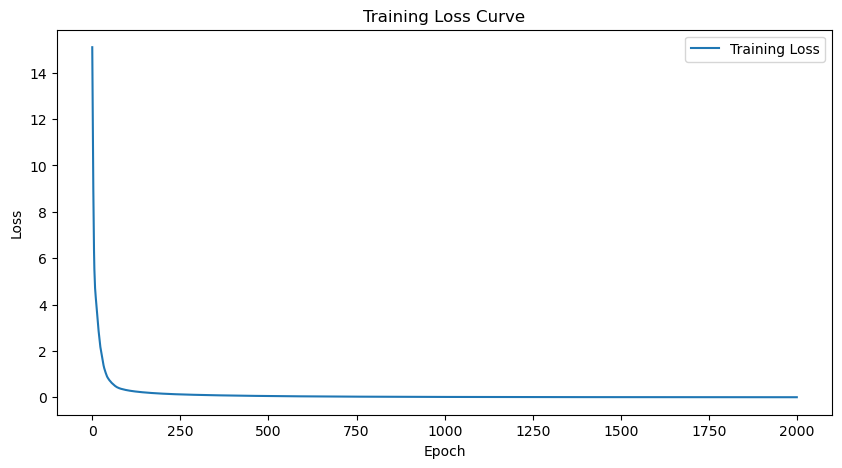

Final Model Accuracy: 74.87%


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token_TSNE3_TSNE3.pth'.


In [11]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       283
non_infringement       0.74      0.80      0.76       298

        accuracy                           0.75       581
       macro avg       0.75      0.75      0.75       581
    weighted avg       0.75      0.75      0.75       581



/tmp/ipykernel_2418755/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
